In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape
from keras.optimizers import Adam
from itertools import combinations
from scipy.sparse import csr_matrix

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

2025-04-20 22:12:18.632698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745187138.873799      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745187138.944035      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# 1. Load and Preprocess Data

# Loading the Data
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    df.dropna(subset=['text'], inplace=True)

    # Clean the Text
    def clean_text(text):
        text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
        text = re.sub(r'\@\w+|\#','', text) # Remove Mentions and Hashtags
        text = re.sub(r'[^A-Za-z\s]', '', text) # Remove Non-Alphabetic Characters
        text = text.lower() # Convert to Lowercase
        return re.sub(r'\s+', ' ', text).strip() # Normalize Whitespace
    
    df['cleaned'] = df['text'].apply(clean_text)
    return df

df = load_and_preprocess('/kaggle/input/merged-file-no-duplicates2/merged_file_no_duplicates2.csv') ### BE SURE TO UPDATE THE DATASET PATH AS NEEDED ###
X = df['cleaned'] # x = cleaned text (features for machine learning)
y = df['label'] # y = corresponding labels (target variables)

print("DONE - Load and Preprocess Data")

DONE - Load and Preprocess Data


In [3]:
# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # using 80:20 split

print("DONE - Train-Test Split")

DONE - Train-Test Split


In [4]:
# 3. Feature Extraction

# TF-IDF
print("Extracting TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# GloVe
print("Extracting GloVe features...")
def load_glove_embeddings(glove_path):
    embeddings_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Load GloVe embeddings (adjust path as needed)
glove_path = '/kaggle/input/glove100/glove.6B.100d.txt'  ### BE SURE TO UPDATE THE DATASET PATH AS NEEDED ###
glove_embeddings = load_glove_embeddings(glove_path)
embedding_dim = 100  # Dimension of GloVe embeddings = 100

def get_glove_embeddings(texts):
    embeddings = []
    for text in texts:
        words = word_tokenize(text)
        vectors = []
        for word in words:
            if word in glove_embeddings:
                vectors.append(glove_embeddings[word])
        if vectors:
            text_embedding = np.mean(vectors, axis=0)
        else:
            text_embedding = np.zeros(embedding_dim)
        embeddings.append(text_embedding)
    return np.array(embeddings)

X_train_glove = get_glove_embeddings(X_train.tolist())
X_test_glove = get_glove_embeddings(X_test.tolist())

print("DONE - Feature Extraction")

Extracting TF-IDF features...
Extracting GloVe features...
DONE - Feature Extraction


In [5]:
# 4. Define Models

# Traditional Machine Learning Models
models = {
    'LightGBM': LGBMClassifier(n_estimators=100, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(n_estimators=100, n_jobs=-1)
}

# Deep Learning Models
# CNN Model (for GloVe embeddings)
def create_cnn(input_shape):
    model = Sequential([
        Reshape((input_shape[0], 1), input_shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# DNN Model
def create_dnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("DONE - Define Models")

DONE - Define Models


In [6]:
# 5. Evaluate Single Models
results = []

def evaluate_single(model, X_train, y_train, X_test, y_test, embedding_name, model_name):
    try:
        if isinstance(model, Sequential):
            if 'CNN' in model_name:
                X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                X_test_rs = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
                model.fit(X_train_rs, y_train, epochs=5, batch_size=32, verbose=0)
                y_pred = (model.predict(X_test_rs) > 0.5).astype(int)
            else:
                model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
                y_pred = (model.predict(X_test) > 0.5).astype(int)
        else:
            if isinstance(X_train, csr_matrix):
                X_train = X_train.toarray()
                X_test = X_test.toarray()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        results.append({
            'Embedding': embedding_name,
            'Model': model_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        })
        return acc
    except Exception as e:
        print(f"Error with {model_name} ({embedding_name}): {str(e)}")
        return 0

print("\nEvaluating single models...")
for name, model in models.items():
    evaluate_single(model, X_train_tfidf, y_train, X_test_tfidf, y_test, 'TF-IDF', name)
    evaluate_single(model, X_train_glove, y_train, X_test_glove, y_test, 'GloVe', name)

# Evaluate neural networks (only with GloVe)
cnn = create_cnn(X_train_glove.shape[1:])
evaluate_single(cnn, X_train_glove, y_train, X_test_glove, y_test, 'GloVe', 'CNN')

dnn = create_dnn(X_train_glove.shape[1])
evaluate_single(dnn, X_train_glove, y_train, X_test_glove, y_test, 'GloVe', 'DNN')

print("DONE - Evaluating Single Models")


Evaluating single models...
[LightGBM] [Info] Number of positive: 38980, number of negative: 41492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.632074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198055
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484392 -> initscore=-0.062452
[LightGBM] [Info] Start training from score -0.062452
[LightGBM] [Info] Number of positive: 38980, number of negative: 41492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484392 -> initscore=-0.062452
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-20 22:23:22.675144: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step
DONE - Evaluating Single Models


In [7]:
# 6. Select Top 4 Models for Hybrids
results_df = pd.DataFrame(results)
top_models = results_df.sort_values(by='Accuracy', ascending=False).head(4)['Model'].unique()

print(f"\nTop 4 models selected for hybrids: {top_models}")

print("DONE - Select Top 4 Models for Hybrids")


Top 4 models selected for hybrids: ['LightGBM' 'Logistic Regression' 'XGBoost' 'DNN']
DONE - Select Top 4 Models for Hybrids


In [8]:
# 7. Create and Evaluate Hybrid Models
hybrid_results = []

def evaluate_hybrid(model1, model2, X_train, y_train, X_test, y_test, embedding_name, hybrid_name):
    try:
        # Handle sparse matrices
        if isinstance(X_train, csr_matrix):
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        
        # Train models
        if isinstance(model1, Sequential):
            if 'CNN' in hybrid_name.split('+')[0].strip():
                X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                model1.fit(X_train_rs, y_train, epochs=5, batch_size=32, verbose=0)
            else:
                model1.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        else:
            model1.fit(X_train, y_train)
        
        if isinstance(model2, Sequential):
            if 'CNN' in hybrid_name.split('+')[1].strip():
                X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                model2.fit(X_train_rs, y_train, epochs=5, batch_size=32, verbose=0)
            else:
                model2.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        else:
            model2.fit(X_train, y_train)
        
        # Get predictions
        if isinstance(model1, Sequential):
            if 'CNN' in hybrid_name.split('+')[0].strip():
                X_test_rs = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
                pred1 = model1.predict(X_test_rs).flatten()
            else:
                pred1 = model1.predict(X_test).flatten()
        else:
            if hasattr(model1, 'predict_proba'):
                pred1 = model1.predict_proba(X_test)[:, 1]
            else:
                pred1 = model1.decision_function(X_test)
                pred1 = (pred1 - pred1.min()) / (pred1.max() - pred1.min())
        
        if isinstance(model2, Sequential):
            if 'CNN' in hybrid_name.split('+')[1].strip():
                X_test_rs = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
                pred2 = model2.predict(X_test_rs).flatten()
            else:
                pred2 = model2.predict(X_test).flatten()
        else:
            if hasattr(model2, 'predict_proba'):
                pred2 = model2.predict_proba(X_test)[:, 1]
            else:
                pred2 = model2.decision_function(X_test)
                pred2 = (pred2 - pred2.min()) / (pred2.max() - pred2.min())
        
        # Combine predictions
        avg_pred = (pred1 + pred2) / 2
        y_pred = (avg_pred > 0.5).astype(int)
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        hybrid_results.append({
            'Embedding': embedding_name,
            'Model': hybrid_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        })
        return acc
    except Exception as e:
        print(f"Error with hybrid {hybrid_name}: {str(e)}")
        return 0

print("\nCreating and evaluating hybrid models...")
model_instances = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(n_estimators=100, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, n_jobs=-1),
    'CNN': create_cnn(X_train_glove.shape[1:]),
    'DNN': create_dnn(X_train_glove.shape[1])
}

# Generate all possible pairs from top models
for (name1, name2) in combinations(top_models, 2):
    hybrid_name = f"{name1} + {name2}"
    print(f"Evaluating hybrid: {hybrid_name}")
    
    m1 = model_instances.get(name1)
    m2 = model_instances.get(name2)
    
    if m1 is None or m2 is None:
        continue
    
    # Evaluate with both embeddings if possible
    if name1 != 'CNN' and name1 != 'DNN' and name2 != 'CNN' and name2 != 'DNN':
        evaluate_hybrid(m1, m2, X_train_tfidf, y_train, X_test_tfidf, y_test, 'TF-IDF', hybrid_name)
    
    evaluate_hybrid(m1, m2, X_train_glove, y_train, X_test_glove, y_test, 'GloVe', hybrid_name)

print("DONE - Create and Evaluate Hybrid Models")


Creating and evaluating hybrid models...
Evaluating hybrid: LightGBM + Logistic Regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[LightGBM] [Info] Number of positive: 38980, number of negative: 41492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.015017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198055
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484392 -> initscore=-0.062452
[LightGBM] [Info] Start training from score -0.062452
[LightGBM] [Info] Number of positive: 38980, number of negative: 41492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484392 -> initscore=-0.062452
[LightGBM] [Info] Start training from score -0.062452
Evalu

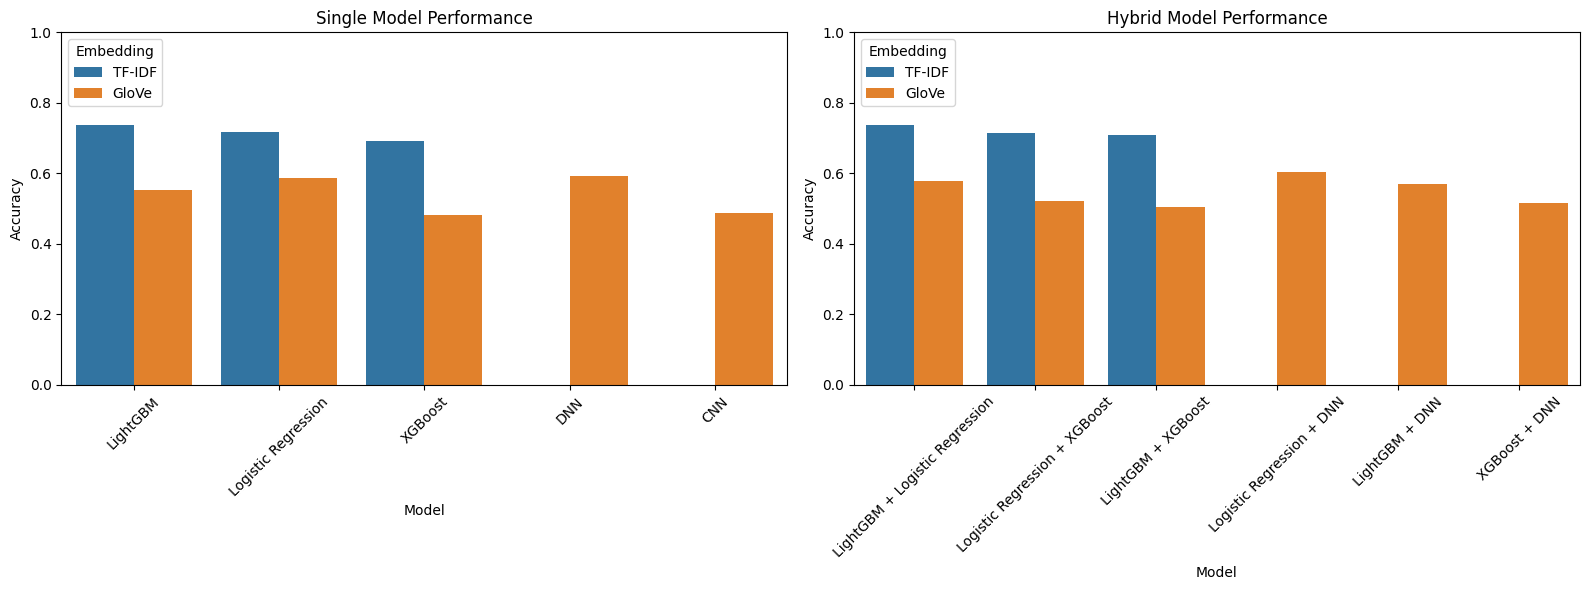

DONE - Accuracy Comparison
[LightGBM] [Info] Number of positive: 38980, number of negative: 41492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.153623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198055
[LightGBM] [Info] Number of data points in the train set: 80472, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484392 -> initscore=-0.062452
[LightGBM] [Info] Start training from score -0.062452
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step


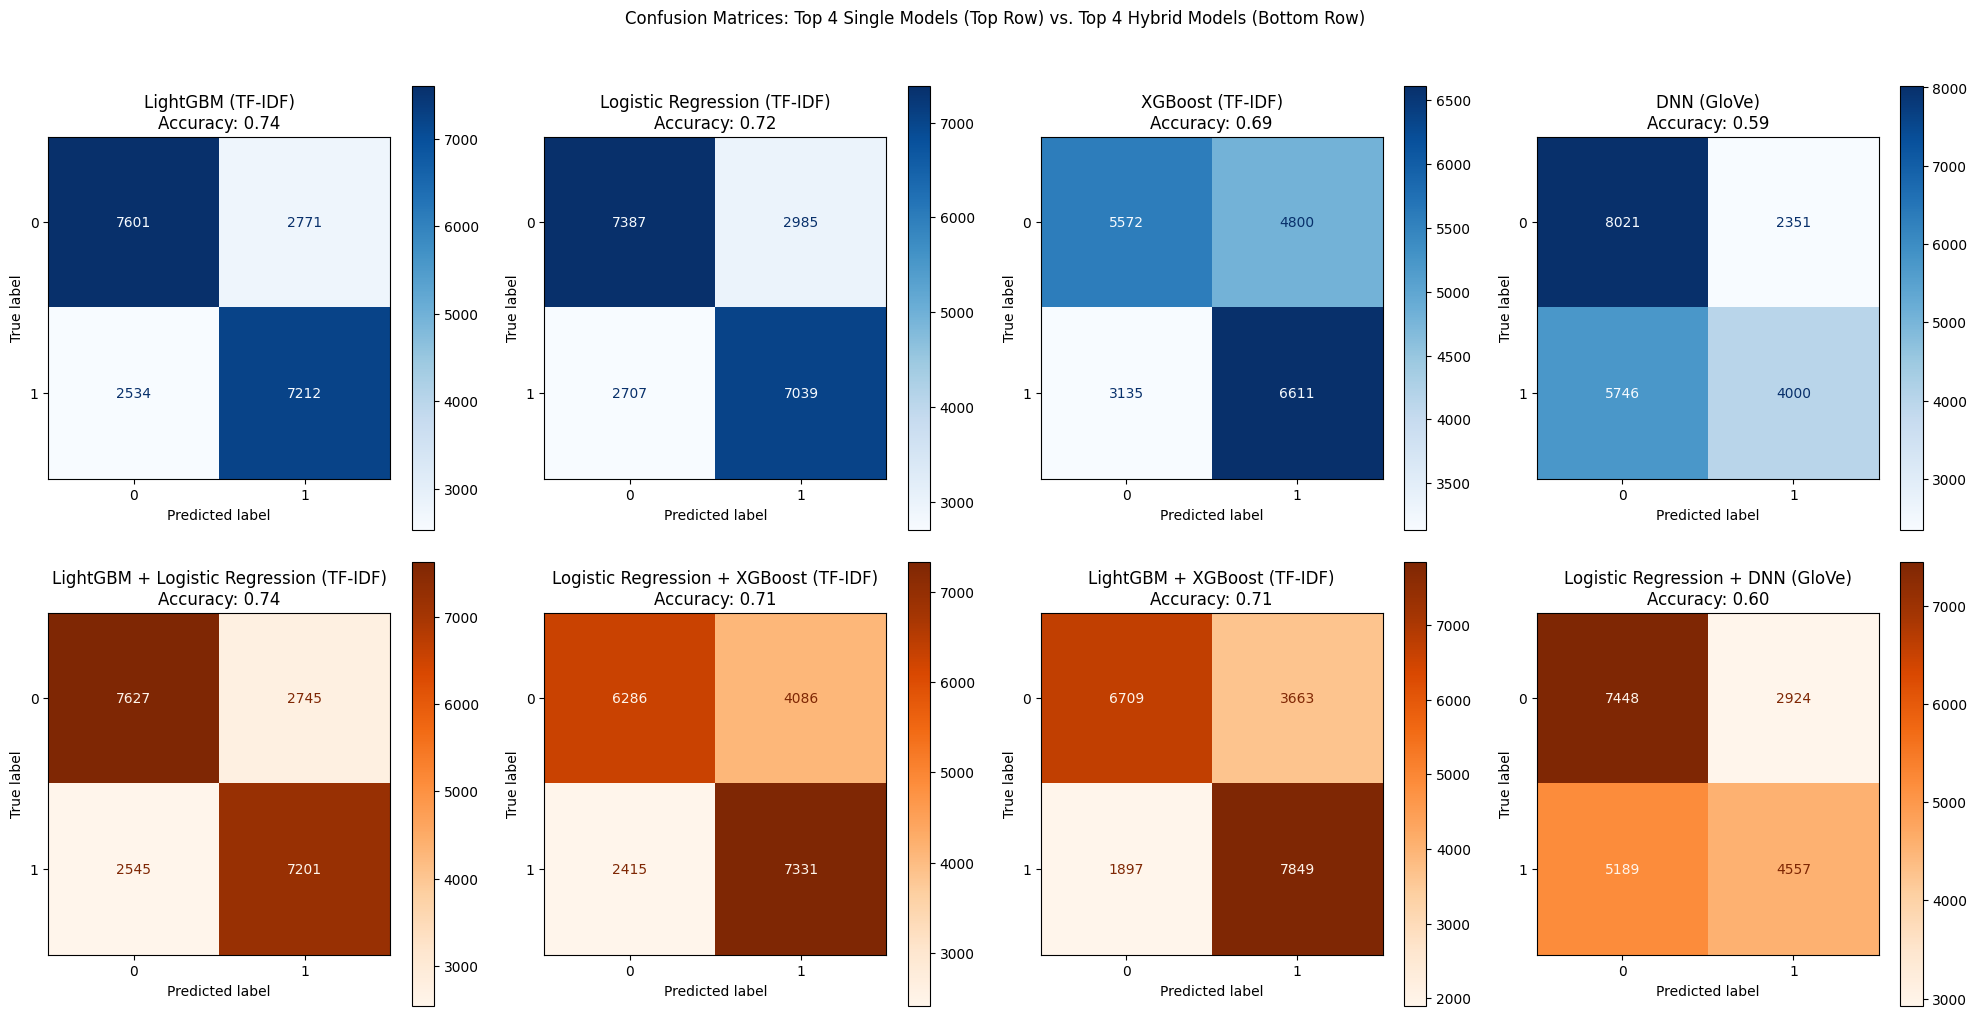

DONE - Confusion Matrices


In [9]:
# 8. Visualize Results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from keras.models import clone_model

# First Figure: Accuracy Comparison
plt.figure(figsize=(16, 6))

# Single models plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', hue='Embedding', 
            data=results_df.sort_values(by='Accuracy', ascending=False))
plt.title('Single Model Performance')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Hybrid models plot
hybrid_df = pd.DataFrame(hybrid_results)
if not hybrid_df.empty:
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Accuracy', hue='Embedding', 
                data=hybrid_df.sort_values(by='Accuracy', ascending=False))
    plt.title('Hybrid Model Performance')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()
print("DONE - Accuracy Comparison")

# Second Figure: Confusion Matrices
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Store trained models with their embeddings
trained_models = {}

# Function to train or retrieve model
def get_trained_model(model_name, embedding, X_train_glove, X_train_tfidf, y_train):
    key = f"{model_name}_{embedding}"
    if key in trained_models:
        return trained_models[key]
    
    model = None
    X_train = X_train_glove if embedding == 'GloVe' else X_train_tfidf
    
    if model_name in model_instances:
        if isinstance(model_instances[model_name], Sequential):
            model = clone_model(model_instances[model_name])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            if 'CNN' in model_name:
                model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
                         y_train, epochs=5, verbose=0)
            else:
                model.fit(X_train, y_train, epochs=5, verbose=0)
        else:
            model = clone(model_instances[model_name])
            model.fit(X_train, y_train)
    elif model_name == 'CNN':
        model = create_cnn(X_train_glove.shape[1:])
        model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
                 y_train, epochs=5, verbose=0)
    elif model_name == 'DNN':
        model = create_dnn(X_train_glove.shape[1])
        model.fit(X_train, y_train, epochs=5, verbose=0)
    
    if model is not None:
        trained_models[key] = model
    return model

# Function to get predictions
def get_predictions(model, model_name, X_test):
    if isinstance(model, Sequential):
        if 'CNN' in model_name:
            X_test_rs = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            preds = model.predict(X_test_rs)
        else:
            preds = model.predict(X_test)
        return preds.flatten()  # Always return 1D array for binary classification
    else:
        if hasattr(model, 'predict_proba'):
            # For binary classification, use positive class probabilities
            return model.predict_proba(X_test)[:, 1] if model.predict_proba(X_test).shape[1] > 1 else model.predict_proba(X_test).flatten()
        else:
            return model.predict(X_test)

# Single Models Confusion Matrices (Top 4)
top_single = results_df.sort_values(by='Accuracy', ascending=False).head(4)
for i, (_, row) in enumerate(top_single.iterrows()):
    model_name = row['Model']
    embedding = row['Embedding']
    
    model = get_trained_model(model_name, embedding, X_train_glove, X_train_tfidf, y_train)
    X_test = X_test_glove if embedding == 'GloVe' else X_test_tfidf
    
    if model is not None:
        if isinstance(X_test, csr_matrix):
            X_test = X_test.toarray()
        
        y_pred = get_predictions(model, model_name, X_test)
        y_pred = (y_pred > 0.5).astype(int)  # Threshold predictions
        
        ax = plt.subplot(2, 4, i+1)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues')
        ax.set_title(f"{model_name} ({embedding})\nAccuracy: {row['Accuracy']:.2f}")

# Hybrid Models Confusion Matrices (Top 4)
if not hybrid_df.empty:
    top_hybrid = hybrid_df.sort_values(by='Accuracy', ascending=False).head(4)
    for i, (_, row) in enumerate(top_hybrid.iterrows()):
        model_names = row['Model'].split(' + ')
        embedding = row['Embedding']
        
        models = []
        valid_models = True
        for name in model_names:
            model = get_trained_model(name, embedding, X_train_glove, X_train_tfidf, y_train)
            if model is None:
                valid_models = False
                break
            models.append(model)
        
        if valid_models and len(models) == 2:
            X_test = X_test_glove if embedding == 'GloVe' else X_test_tfidf
            
            if isinstance(X_test, csr_matrix):
                X_test = X_test.toarray()
            
            preds = []
            for model, name in zip(models, model_names):
                pred = get_predictions(model, name, X_test)
                preds.append(pred)
            
            avg_pred = np.mean(preds, axis=0)
            y_pred = (avg_pred > 0.5).astype(int)
            
            ax = plt.subplot(2, 4, i+5)
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=ax, cmap='Oranges')
            ax.set_title(f"{row['Model']} ({embedding})\nAccuracy: {row['Accuracy']:.2f}")

plt.suptitle("Confusion Matrices: Top 4 Single Models (Top Row) vs. Top 4 Hybrid Models (Bottom Row)", y=1.02)
plt.tight_layout()
plt.show()

print("DONE - Confusion Matrices")

In [10]:
# 9. Save and Print Results
results_df.to_csv("single_model_results.csv", index=False)
hybrid_df.to_csv("hybrid_model_results.csv", index=False)

print("\n=== Best Single Models ===")
print(results_df.sort_values(by='Accuracy', ascending=False).head(10)) # pick top 10 model

if not hybrid_df.empty:
    print("\n=== Best Hybrid Models ===")
    print(hybrid_df.sort_values(by='Accuracy', ascending=False).head(10)) # pick top 10 model

print("DONE - Save and Print Results")


=== Best Single Models ===
  Embedding                Model  Accuracy  Precision    Recall  F1 Score
0    TF-IDF             LightGBM  0.736306   0.736630  0.736306  0.736366
2    TF-IDF  Logistic Regression  0.717069   0.717487  0.717069  0.717137
4    TF-IDF              XGBoost  0.692812   0.692998  0.692812  0.692867
7     GloVe                  DNN  0.591808   0.594007  0.591808  0.591423
3     GloVe  Logistic Regression  0.586341   0.586320  0.586341  0.583105
1     GloVe             LightGBM  0.551894   0.551066  0.551894  0.546550
6     GloVe                  CNN  0.487921   0.507203  0.487921  0.368848
5     GloVe              XGBoost  0.480962   0.478731  0.480962  0.478160

=== Best Hybrid Models ===
  Embedding                           Model  Accuracy  Precision    Recall  \
0    TF-IDF  LightGBM + Logistic Regression  0.736902   0.737160  0.736902   
5    TF-IDF   Logistic Regression + XGBoost  0.714783   0.714972  0.714783   
2    TF-IDF              LightGBM + XGBoost 